# `strymread` tutorial
## Analyzing CAN data logged from Giraffee and Panda

### Prerequisite
- Install strym package from git: `pip install git+https://github.com/jmscslgroup/strym.git`
A detailed instruction about installation is available at https://github.com/jmscslgroup/strym/blob/master/README.md

In [1]:
import strym
from strym import strymread
from strym import ranalyze
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import strym.DBC_Read_Tools as dbc
import numpy as np
from scipy.interpolate import interp1d
plt.rcParams["figure.figsize"] = (16,8)
rcParams.update({'font.size': 40})
dbcfile = '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc'
r =strymread(csvfile="/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_02_18/2020-02-18-13-00-42-209119__CAN_Messages.csv", dbcfile=dbcfile)


Loading BokehJS ...

## We will visualize the counts of all messages
The plot is split into several subplots for brevity.

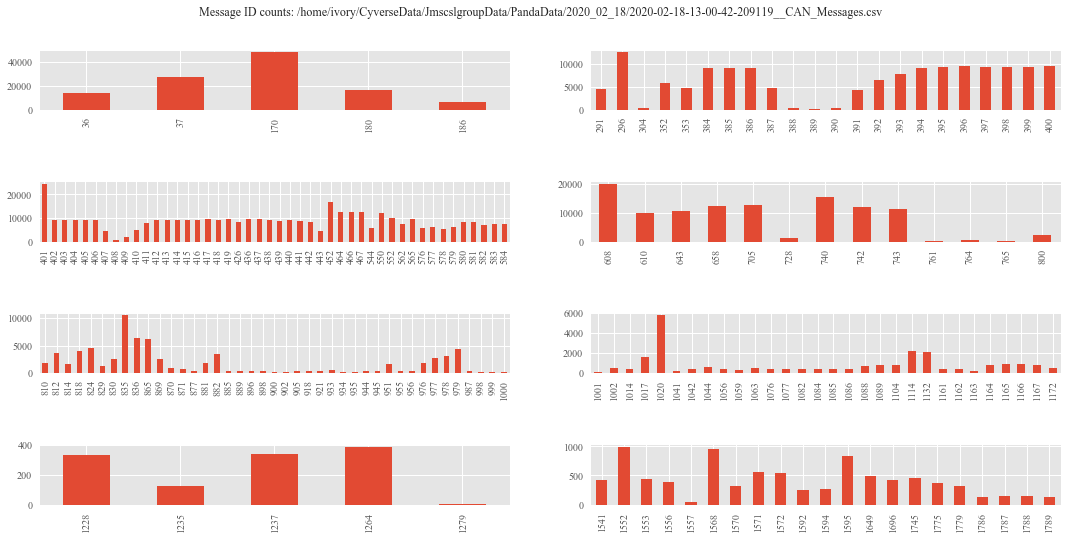

In [2]:
r.count()

## Let's plot a few important data
### Speed

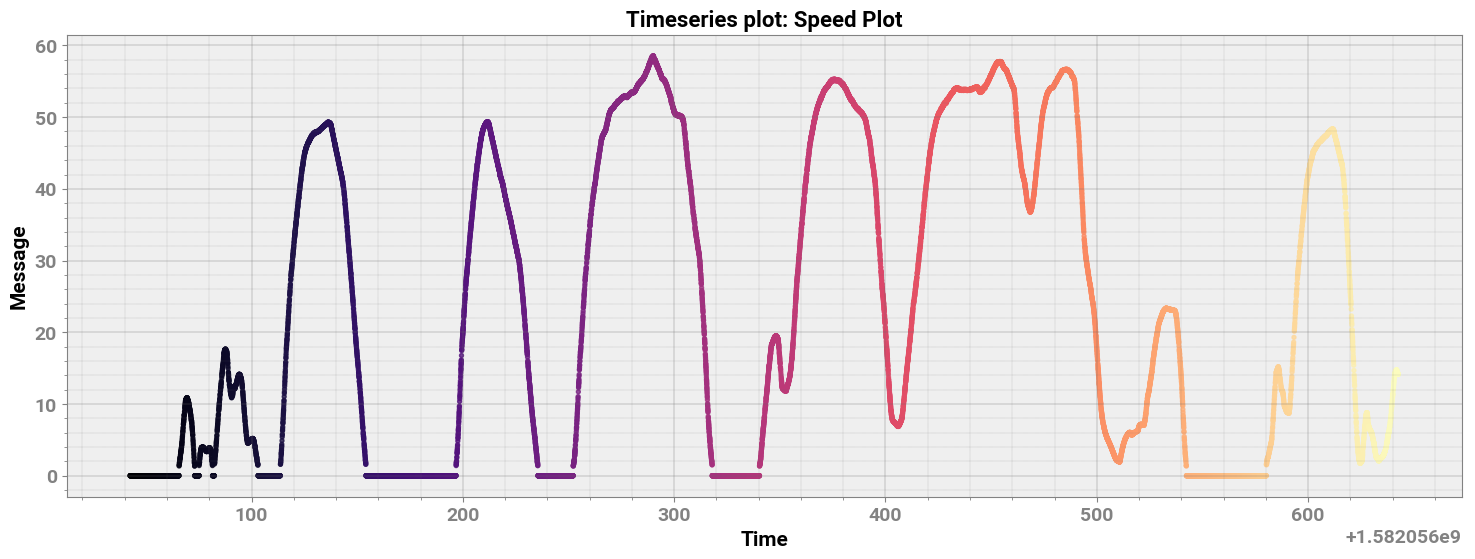

In [3]:
speed = r.speed()
strym.plt_ts(speed, title="Speed Plot")

## Lets visualize a message with given message ID and  signal ID


In [4]:
msg869 = r.get_ts(869, 6)
msg869

,Time,Message
Clock,,
2020-02-18 20:00:42.563222170,1.582056e+09,252
2020-02-18 20:00:42.762883186,1.582056e+09,252
2020-02-18 20:00:42.962881088,1.582056e+09,252
2020-02-18 20:00:43.163354397,1.582056e+09,252
2020-02-18 20:00:43.362929344,1.582056e+09,252
...,...,...
2020-02-18 20:10:41.780860662,1.582057e+09,252
2020-02-18 20:10:41.981138706,1.582057e+09,252
2020-02-18 20:10:42.180863142,1.582057e+09,252


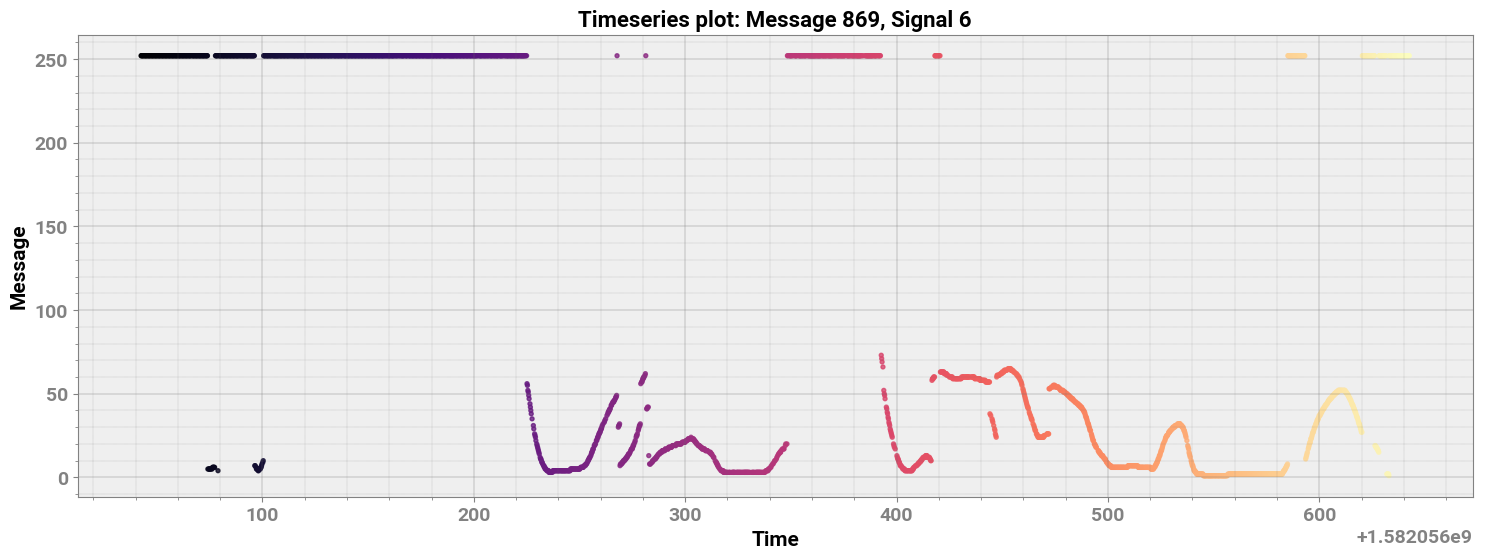

In [5]:
strym.plt_ts(msg869, title="Message 869, Signal 6")

## Rate Statistics for every message ID

In [6]:
u = r.frequency()
u

,MessageID,MeanRate,MedianRate,RateStd,MaxRate,MinRate,RateIQR
0,36,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
1,37,67.288051,93.673039,34.281383,113.289145,4.164077,66.777901
2,170,89.278407,99.719550,22.075659,109.403307,9.971836,2.379852
3,180,34.673094,25.145707,14.538821,52.151095,3.576015,25.053590
4,186,18.614265,16.655365,11.307187,34.657368,1.852362,24.319035
...,...,...,...,...,...,...,...
178,1779,0.805903,0.998280,0.300885,1.010311,0.058821,0.501203
179,1786,0.280289,0.333355,0.089236,0.333481,0.030307,0.166683
180,1787,0.298923,0.333355,0.077203,0.333494,0.055560,0.000043
181,1788,0.290716,0.333352,0.082196,0.333524,0.055558,0.000087


## Synchronize Two Time Series messages and resample with a fixed datarate


It means first time of speed is earlier than yaw in time-series data so we have to interpolate speed value at yaw's first time. We will use linear interpolation.

Linear interpolation formula is 

$$
X_i = \cfrac{X_A - X_B}{a-b}(i-b) + X_B
$$

In [7]:
ts_yaw_rate = r.yaw_rate()
ts_speed = r.speed()

# integrate yaw rate to get the heading
ts_yaw = strym.integrate(ts_yaw_rate)

In [8]:
interpolated_speed, interpolated_yaw = strym.ts_sync(ts_speed, ts_yaw)

Text(0, 0.5, 'Message')

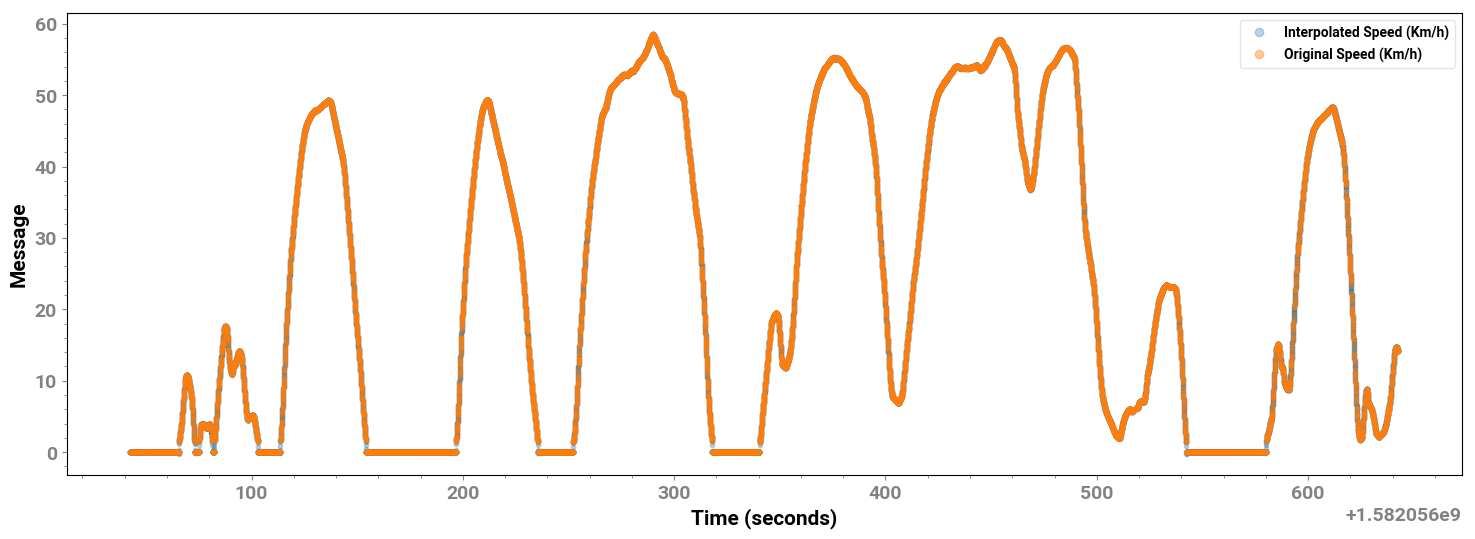

In [9]:
plt.plot(interpolated_speed['Time'], interpolated_speed['Message'], ".", alpha=0.3)
plt.plot(ts_speed['Time'], ts_speed['Message'], ".", alpha=0.4)
plt.legend(['Interpolated Speed (Km/h)', 'Original Speed (Km/h)'])
plt.xlabel('Time (seconds)')
plt.ylabel('Message')

Text(0, 0.5, 'Message')

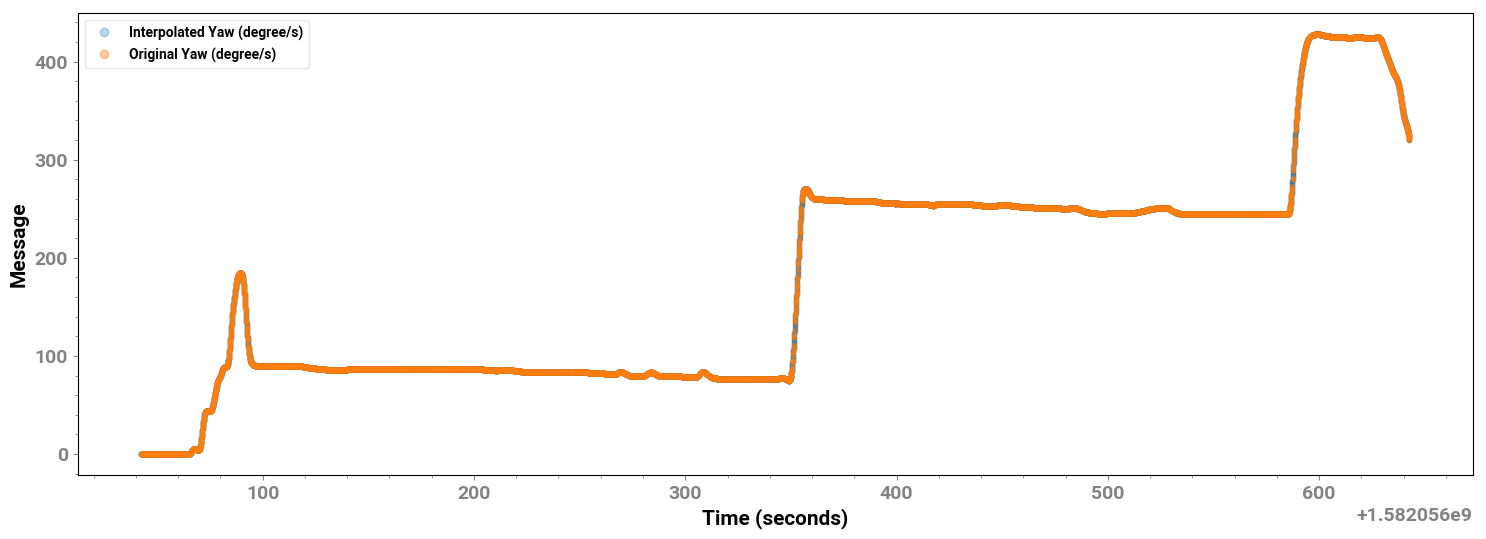

In [10]:
plt.plot(interpolated_yaw['Time'], interpolated_yaw['Message'], ".", alpha=0.3)
plt.plot(ts_yaw['Time'], ts_yaw['Message'], ".", alpha=0.4)
plt.legend(['Interpolated Yaw (degree/s)', 'Original Yaw (degree/s)'])
plt.xlabel('Time (seconds)')
plt.ylabel('Message')

## Plot the trajectory of vehice based on kinematic model using yaw rate and speed

In [11]:
T = r.trajectory()

Text(0, 0.5, 'Y [m]')

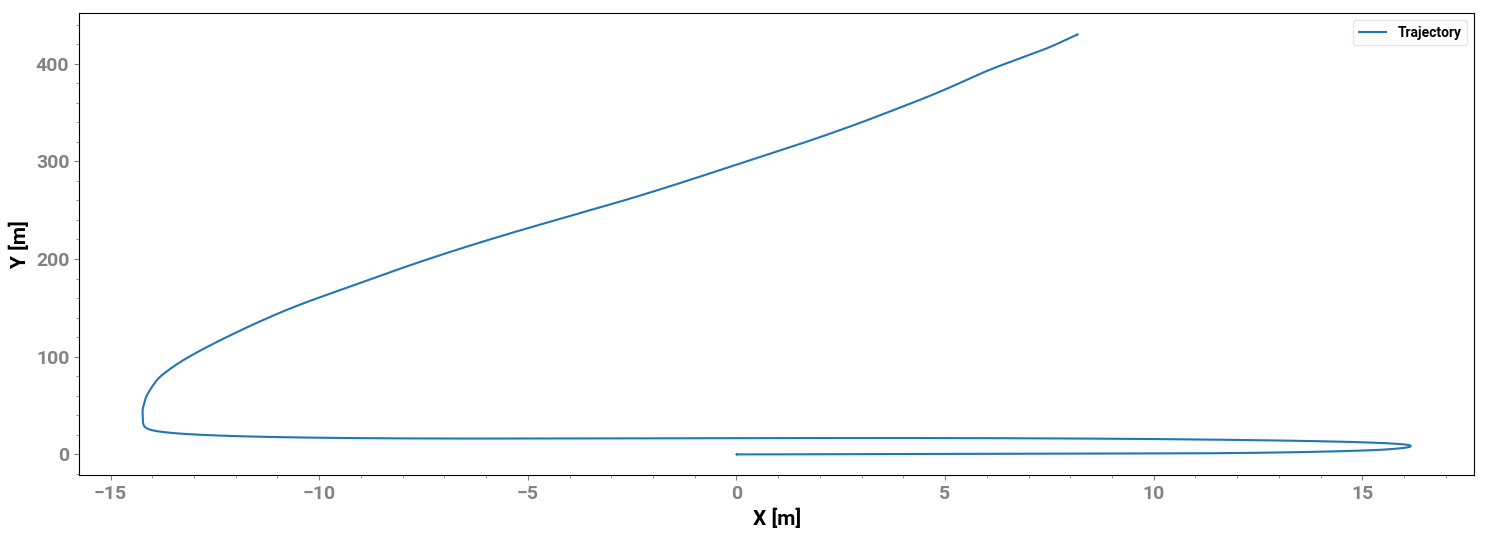

In [12]:
plt.plot(T['X'].iloc[1:7501], T['Y'].iloc[1:7501])
plt.legend(['Trajectory'])
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

In [13]:
T[1:7500]

,Time,X,Y,Vx,Vy
1,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
2,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
3,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
4,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
5,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...
7495,1.582056e+09,8.176946,429.901071,-2.273493e-80,-4.492456e-79
7496,1.582056e+09,8.176946,429.901071,4.285837e-80,8.468876e-79
7497,1.582056e+09,8.176946,429.901071,-1.544180e-79,-3.051322e-78
7498,1.582056e+09,8.176946,429.901071,5.679758e-79,1.122329e-77


## Get the meta data about driving 

In [14]:
metadata = r.driving_characteristics()

In [15]:
metadata

{'filename': '/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_02_18/2020-02-18-13-00-42-209119__CAN_Messages.csv',
 'dbcfile': '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc',
 'distance_meters': 3937.1090472204933,
 'distance_km': 3.9371090472204933,
 'distance_miles': 2.4464122231601113,
 'start_time': 'Tue Feb 18 13:00:42 2020',
 'end_time': 'Tue Feb 18 13:10:42 2020',
 'trip_time': 600.1924126148224}

## Get the distribution of data
### We will show the distribution of speed data

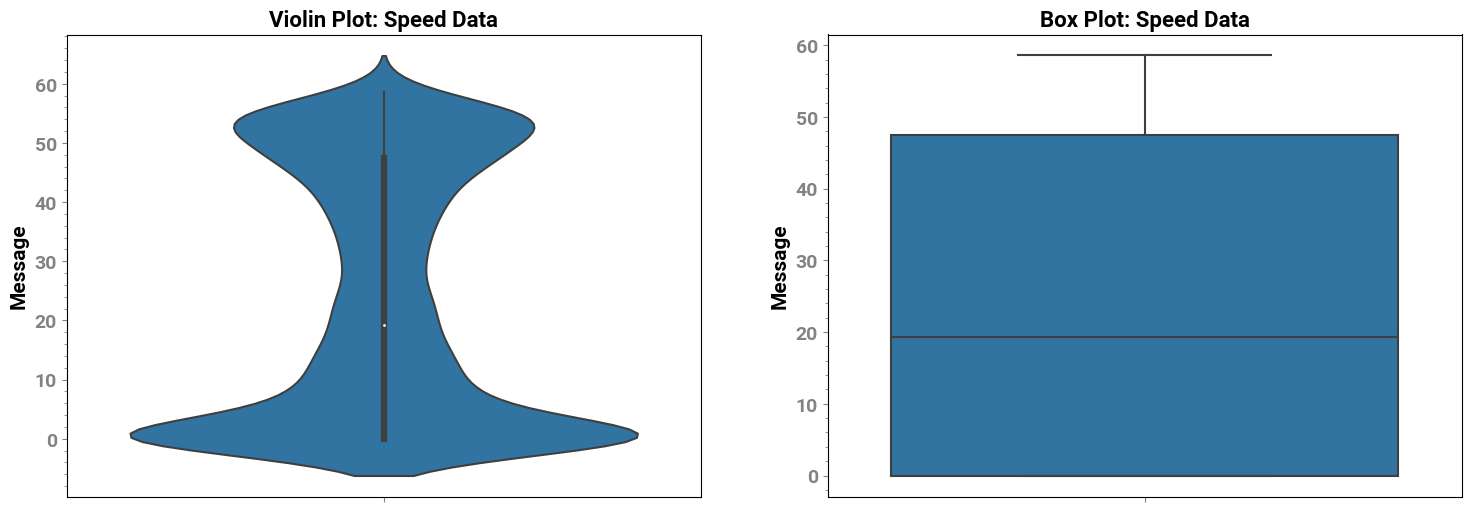

In [16]:
speed = r.speed()
strym.violinplot(speed['Message'], title="Speed Data")

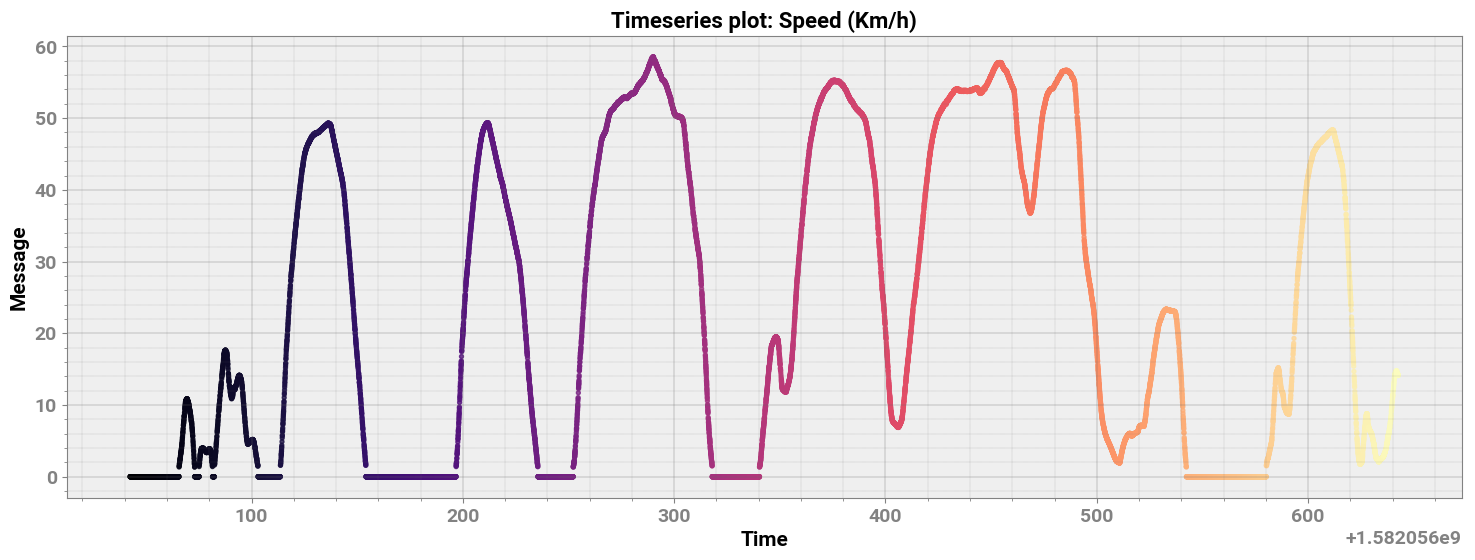

In [17]:
strym.plt_ts(speed, title='Speed (Km/h)')

## Rate Analysis for specific messages
Let's say we want to analyze data throughput aka rate for Radar data.
For this specific example, we will be looking at TRACK_A_0. For that we will call the appropriate function to retreive longitudinal data corresponding to TRACK_A_0.

Analyzing Timestamp and Data Rate of Longitudinal Distance Data: TRACK A 0
Interquartile Range of Rate for Longitudinal Distance Data: TRACK A 0 is 10.065492882674468 


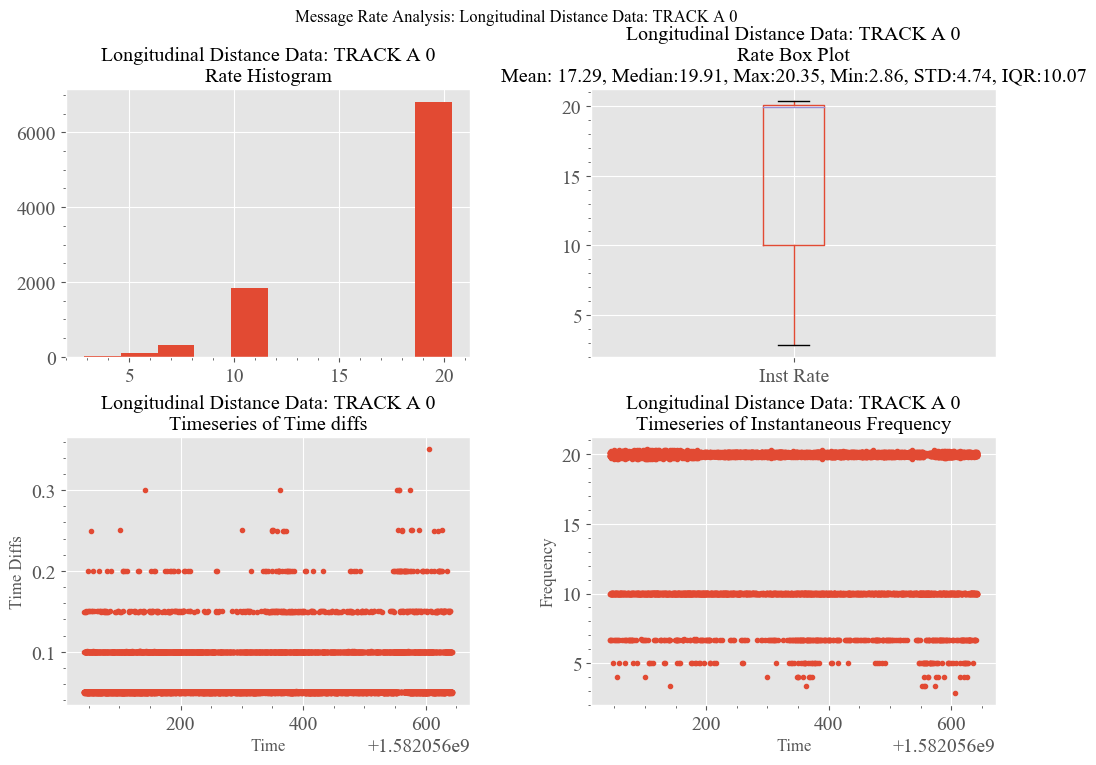

In [20]:
track_id = np.arange(0, 1) # I want to analyze rate for TRACK_A_0 only
long_dist = r.long_dist(track_id)

strym.ranalyze(long_dist[0], title='Longitudinal Distance Data: TRACK A 0')